In [1]:
import os
import time
import scipy
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
onColab = True
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE1/with_img_divided
  !ls

Mounted at /gdrive
/gdrive/MyDrive/University/ANN/CHALLENGE1/with_img_divided
ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses
ckpt_EfficientNetB7_best_180_denselayerft_new_DS_weightOnClasses
ckpt_ResNet50_best_128_denselayerft_new_DS_weightOnClasses
dataset.zip
EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses
my_net.ipynb
on_new_ds_new_pipeline.ipynb
on_new_ds_new_pipeline_no_hidden.ipynb
ResNet50_best_128_denselayerft_new_DS_weightOnClasses
training


In [7]:
doUnzipData = False
batch_size = 256
validation_split = 0.3

if doUnzipData:
  !unzip dataset.zip

In [3]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
dataset_path = './training'
img_h, img_w = (256, 256)
test_path = './test'


def load_data(dontUseFun=True, fun=None, isTest = False):
  """
  load data (train, val, test)
  dontUseFun: if it's true then the data is not preprocessed. If it's false, the data is preprocessed with fun (which must not be none)
  """
  image_generator = ImageDataGenerator(preprocessing_function = fun, validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  
  if dontUseFun:
    image_generator = ImageDataGenerator(validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  


  # Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
  train_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='training',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)

  valid_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='validation',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)
  test_gen = None
  if isTest:
    test_image_gen = ImageDataGenerator(preprocessing_function = fun)
    if dontUseFun:
      test_image_gen = ImageDataGenerator(rotation_range=30)
    
    test_gen = test_image_gen.flow_from_directory(directory=test_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True, # sometimes, instead of train, we use the test for training
                                                seed=seed)
  return train_gen, valid_gen, test_gen


In [6]:
# # we need this ONLY for the labels
# train_gen = load_data(True, None, False)[0]
# labels = list(train_gen.class_indices.keys())


In [5]:
labels = ['Apple', 'Apple_ill', 'Blueberry', 'Cherry', 'Cherry_ill', 'Corn_in', 'Corn_out', 'Grape', 'Grape_ill', 'Orange', 'Peach', 'Peach_ill', 'Pepper', 'Pepper_ill', 'Potato', 'Potato_ill', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Strawberry_ill', 'Tomato_green', 'Tomato_others']

In [8]:
create_test_set = False

# IF YOU CHANGE NET GO CHECK THE FINE TUNING CODE IF IT IS ALRIGHT!

model_dir = 'EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses'

# Highly dependent on the network chosen:
n_not_trainable_layers = -1

net = tfk.applications.EfficientNetB1


def tl_preprocess(x):
  return tf.keras.applications.efficientnet.preprocess_input(x)

def compute_weight(val_split):
  w = []
  for i in range(len(labels)):
    class_imgs = next(os.walk('{}/{}/'.format('./training', labels[i])))[2]
    w.append(len(class_imgs) * (1 - val_split))

  tot = sum(w)
  for i in range(len(w)):
    w[i] = tot / w[i]
  m = max(w)
  w = np.array(w) / m
  w[np.argmax(w)] = 0.99999999999999
  d = {}
  for i in range(len(w)):
    d[i] = w[i]
  return d

# weights computed for validation split = 0.3
class_weight = {0: 0.17416829745596868, 1: 0.18936170212765957, 2: 0.19139784946236557, 3: 0.3423076923076923, 4: 0.27899686520376177, 5: 0.24929971988795518, 6: 0.10607866507747318, 7: 0.2908496732026144, 8: 0.0778652668416448, 9: 0.051061388410786, 10: 0.34765625000000006, 11: 0.12378303198887343, 12: 0.1943231441048035, 13: 0.2947019867549669, 14: 0.99999999999999, 15: 0.14217252396166133, 16: 0.33712121212121215, 17: 0.05517668939863608, 18: 0.16729323308270677, 19: 0.2680722891566265, 20: 0.27217125382262997, 21: 0.1790744466800805, 22: 0.017342166796570538}

mappings = {
    0: 0, 1: 0,
    2: 1,
    3: 2, 4: 2,
    5: 3, 6: 3,
    7: 4, 8: 4,
    9: 5,
    10: 6, 11: 6,
    12: 7, 13: 7,
    14: 8, 15: 8,
    16: 9, 
    17: 10,
    18: 11,
    19: 12, 20: 12,
    21: 13, 22: 13
}
drop_out_last_dense = 0
fc_dense_n_neurons = 0

comment = 'EfficientNetB7, transfer learning, no fine tuning. GAP used. no hidden dense layer with drop out'
comment += '\nnot trainable layers: ' + str(n_not_trainable_layers)
comment += ' drop_out_last_dense ' + str(drop_out_last_dense)
comment += ' fc_dense_n_neurons ' + str(fc_dense_n_neurons)
comment += '\nvalidation_split = ' + str(validation_split) 
comment += '. batch_size = ' + str(batch_size) 
comment += '. seed = ' + str(seed)
comment += '\nweigths: '
comment += str(class_weight)
print(comment)

EfficientNetB7, transfer learning, no fine tuning. GAP used. no hidden dense layer with drop out
not trainable layers: -1 drop_out_last_dense 0 fc_dense_n_neurons 0
validation_split = 0.3. batch_size = 256. seed = 20
weigths: {0: 0.17416829745596868, 1: 0.18936170212765957, 2: 0.19139784946236557, 3: 0.3423076923076923, 4: 0.27899686520376177, 5: 0.24929971988795518, 6: 0.10607866507747318, 7: 0.2908496732026144, 8: 0.0778652668416448, 9: 0.051061388410786, 10: 0.34765625000000006, 11: 0.12378303198887343, 12: 0.1943231441048035, 13: 0.2947019867549669, 14: 0.99999999999999, 15: 0.14217252396166133, 16: 0.33712121212121215, 17: 0.05517668939863608, 18: 0.16729323308270677, 19: 0.2680722891566265, 20: 0.27217125382262997, 21: 0.1790744466800805, 22: 0.017342166796570538}


In [9]:
if create_test_set:
  import shutil
  os.mkdir(test_path)
  for i in range(len(labels)):
      class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
      # In this way we always get the same data. 
      # TODO: randomize using seed the data we take
      class_imgs.sort()
      for j in range(5):
        class_img = class_imgs[j]
        dest_dir = './test/' + labels[i] + '/'
        if not os.path.exists(dest_dir):
          os.mkdir(dest_dir)
        shutil.move('{}/{}/'.format(dataset_dir, labels[i]) + class_img, dest_dir)


In [10]:
def preprocess(x):
  # x = clean_image(x)
  if tl_preprocess:
    return tl_preprocess(np.uint8(x))
  return x

In [11]:
train_gen, valid_gen, test_gen = load_data(False, preprocess)

Found 12304 images belonging to 23 classes.
Found 5256 images belonging to 23 classes.


In [12]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(image)
  plt.title("image which will be fed to the cnn")
  return batch

# Get a sample from dataset and show info
# _ = get_next_batch(train_gen)

In [13]:
supernet =  net(
    weights="imagenet",
    input_shape=(img_h, img_w, 3),
    include_top=False
    )

27033600/27018416 [==============================] - 0s 0us/step


In [14]:
print(len(supernet.layers))

339


In [15]:
# let last block trainable
for i, layer in enumerate(supernet.layers[:n_not_trainable_layers]):
  layer.trainable=False
for i, layer in enumerate(supernet.layers):
  print(i, layer.name, layer.trainable)
# supernet.summary()

# Now we use the supernet as layer of our network
inputs = tfk.Input(shape=(img_h, img_w, 3))
x = supernet(inputs)

# Now we build our classifier (which will be actually trained)
x = tfkl.GlobalAveragePooling2D(name="avg_pool")(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    len(labels), 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

model.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_se_ex

In [16]:
c = [tfk.callbacks.ModelCheckpoint('./ckpt_' + model_dir, save_best_only=True), tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)] 
history = model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = 200,
    validation_data = valid_gen,
    class_weight = class_weight,
    callbacks = c
).history

Epoch 1/200
49/49 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.5090 INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 2429s 50s/step - loss: 0.1938 - accuracy: 0.5090 - val_loss: 1.6465 - val_accuracy: 0.6041
Epoch 2/200
49/49 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.7784INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 415s 9s/step - loss: 0.0707 - accuracy: 0.7784 - val_loss: 1.0617 - val_accuracy: 0.8162
Epoch 3/200
49/49 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.8344INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 415s 9s/step - loss: 0.0516 - accuracy: 0.8344 - val_loss: 0.7220 - val_accuracy: 0.8794
Epoch 4/200
49/49 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.8608INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 406s 8s/step - loss: 0.0429 - accuracy: 0.8608 - val_loss: 0.5225 - val_accuracy: 0.9148
Epoch 5/200
49/49 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.8709INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 417s 9s/step - loss: 0.0358 - accuracy: 0.8709 - val_loss: 0.3828 - val_accuracy: 0.9269
Epoch 6/200
49/49 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.8839INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 417s 9s/step - loss: 0.0311 - accuracy: 0.8839 - val_loss: 0.2890 - val_accuracy: 0.9462
Epoch 7/200
49/49 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.8928INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 410s 8s/step - loss: 0.0292 - accuracy: 0.8928 - val_loss: 0.2526 - val_accuracy: 0.9410
Epoch 8/200
49/49 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9004INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 408s 8s/step - loss: 0.0270 - accuracy: 0.9004 - val_loss: 0.2316 - val_accuracy: 0.9412
Epoch 9/200
49/49 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.8978INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 421s 9s/step - loss: 0.0240 - accuracy: 0.8978 - val_loss: 0.2054 - val_accuracy: 0.9482
Epoch 10/200
49/49 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9121INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 425s 9s/step - loss: 0.0237 - accuracy: 0.9121 - val_loss: 0.1971 - val_accuracy: 0.9425
Epoch 11/200
49/49 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9105INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 426s 9s/step - loss: 0.0220 - accuracy: 0.9105 - val_loss: 0.1825 - val_accuracy: 0.9488
Epoch 12/200
49/49 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9156INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 411s 8s/step - loss: 0.0211 - accuracy: 0.9156 - val_loss: 0.1668 - val_accuracy: 0.9507
Epoch 13/200
49/49 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9166INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 426s 9s/step - loss: 0.0201 - accuracy: 0.9166 - val_loss: 0.1536 - val_accuracy: 0.9534
Epoch 14/200
49/49 [==============================] - 347s 7s/step - loss: 0.0193 - accuracy: 0.9217 - val_loss: 0.1545 - val_accuracy: 0.9538
Epoch 15/200
49/49 [==============================] - 343s 7s/step - loss: 0.0185 - accuracy: 0.9204 - val_loss: 0.1541 - val_accuracy: 0.9528
Epoch 16/200
49/49 [==============================] - 341s 7s/step - loss: 0.0180 - accuracy: 0.9260 - val_loss: 0.1642 - val_accuracy: 0.9494
Epoch 17/200
49/49 [==============================] - 305s 6s/step - loss: 0.0174 - accuracy: 0.9264 - val_loss: 0.2122 - val_accuracy: 0.9258
Epoch 18/200
49/49 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9152INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 377s 8s/step - loss: 0.0185 - accuracy: 0.9152 - val_loss: 0.1436 - val_accuracy: 0.9538
Epoch 19/200
49/49 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9251INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 384s 8s/step - loss: 0.0185 - accuracy: 0.9251 - val_loss: 0.1349 - val_accuracy: 0.9581
Epoch 20/200
49/49 [==============================] - 303s 6s/step - loss: 0.0168 - accuracy: 0.9296 - val_loss: 0.1487 - val_accuracy: 0.9553
Epoch 21/200
49/49 [==============================] - 307s 6s/step - loss: 0.0177 - accuracy: 0.9233 - val_loss: 0.1396 - val_accuracy: 0.9551
Epoch 22/200
49/49 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9331INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 379s 8s/step - loss: 0.0151 - accuracy: 0.9331 - val_loss: 0.1255 - val_accuracy: 0.9606
Epoch 23/200
49/49 [==============================] - 305s 6s/step - loss: 0.0149 - accuracy: 0.9342 - val_loss: 0.1319 - val_accuracy: 0.9581
Epoch 24/200
49/49 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9292INFO:tensorflow:Assets written to: ./ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


49/49 [==============================] - 381s 8s/step - loss: 0.0157 - accuracy: 0.9292 - val_loss: 0.1203 - val_accuracy: 0.9604
Epoch 25/200
49/49 [==============================] - 305s 6s/step - loss: 0.0147 - accuracy: 0.9347 - val_loss: 0.1276 - val_accuracy: 0.9576
Epoch 26/200
49/49 [==============================] - 303s 6s/step - loss: 0.0143 - accuracy: 0.9419 - val_loss: 0.1321 - val_accuracy: 0.9570
Epoch 27/200
49/49 [==============================] - 302s 6s/step - loss: 0.0149 - accuracy: 0.9384 - val_loss: 0.1353 - val_accuracy: 0.9549


In [17]:
model.save('./' + model_dir)

INFO:tensorflow:Assets written to: ./EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [18]:
# model.evaluate(test_gen, return_dict=True)

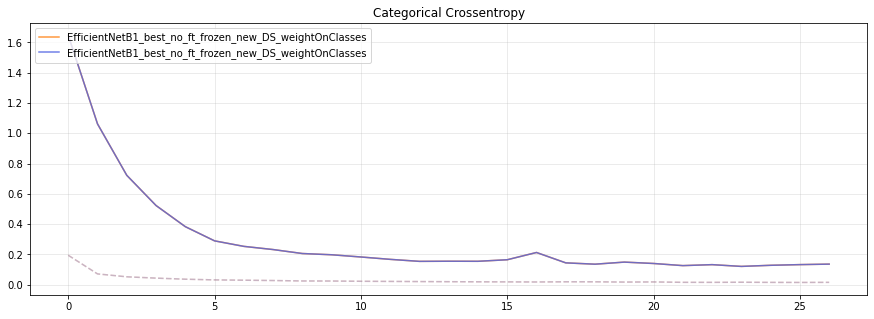

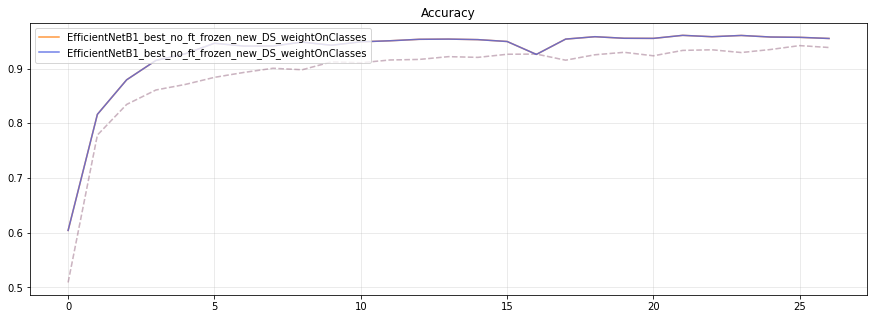

In [19]:
def compareModels(history1, h1lbl, history2=None, h2lbl=''):
  '''
  Plot history1 against history2. 
  If history2 is None then Plot twice history1 (it'll be overlapped)
  h1lbl and h2lbl are the labels of the two histories
  '''
  if history2 == None: 
    history2 = history1
    h2lbl = h1lbl
  # Plot the training
  plt.figure(figsize=(15,5))
  plt.plot(history1['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(history1['val_loss'], label=h1lbl, alpha=.8, color='#ff7f0e')
  plt.plot(history2['loss'], alpha=.3, color='#4D61E2', linestyle='--')
  plt.plot(history2['val_loss'], label=h2lbl, alpha=.8, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=.3)

  plt.figure(figsize=(15,5))
  plt.plot(history1['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(history1['val_accuracy'], label=h1lbl, alpha=.8, color='#ff7f0e')
  plt.plot(history2['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
  plt.plot(history2['val_accuracy'], label=h2lbl, alpha=.8, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.show()
compareModels(history, model_dir)

In [12]:
model = tf.keras.models.load_model('./' + model_dir)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[ 143    3    0    1    0    0    0    0    0    0    2    0    1    0
     0    0    0    3    0    0    0    0    0]
 [   3  131    1    1    2    0    0    0    0    0    0    1    0    0
     0    0    0    0    1    0    0    1    0]
 [   1    0  136    0    1    0    0    0    0    1    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0   77    0    0    0    0    0    0    0    0    0    0
     0    0    0    1    0    0    0    0    0]
 [   0    0    0    0   95    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  107    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0  251    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0   91    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    1    0    0  

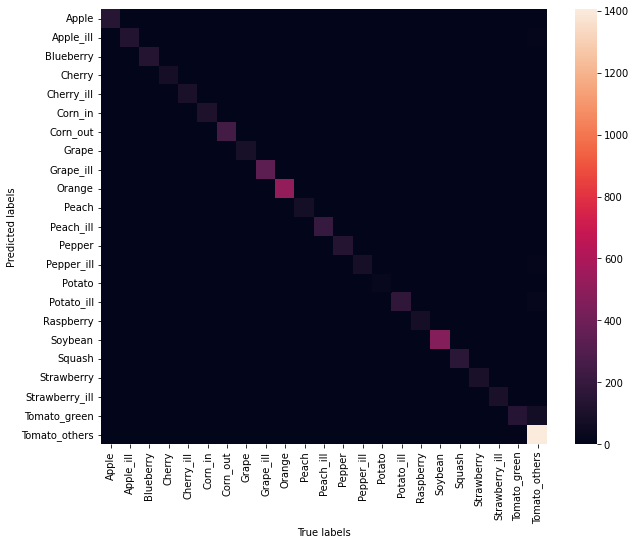

In [17]:
# Plot the confusion matrix
import seaborn as sns
cm = confusion_matrix(valid_gen.classes, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [19]:
# # Compute the classification metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
target = valid_gen.classes
predictions = Y_pred
accuracy = accuracy_score(target, np.argmax(predictions, axis=1))
precision = precision_score(target, np.argmax(predictions, axis=1), average='macro')
recall = recall_score(target, np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(target, np.argmax(predictions, axis=1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

Accuracy: 0.9589
Precision: 0.9403
Recall: 0.9733
F1: 0.9552
